# 자전거 대여 수요 예측 경진대회 모델링

- [자전거 대여 수요 예측 경진대회 링크](https://www.kaggle.com/c/bike-sharing-demand)

- [모델링 노트북 참고 링크](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)

In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv("/kaggle/input/train.csv")
test = pd.read_csv("/kaggle/input/test.csv")
submission = pd.read_csv("/kaggle/input/sampleSubmission.csv")

In [2]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [3]:
all_data_temp = pd.concat([train, test], ignore_index=False)
all_data_temp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [4]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


## 피처 엔지니어링

In [5]:
from datetime import datetime

all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0]) # 날짜 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0]) # 연도 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1]) # 월 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0]) # 시 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday()) # 요일 피처 생성

#### 범주형 데이터 타입 변경

In [6]:
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'weekday', 'month', 'year', 'hour']

for feature in categorical_features:
    all_data[feature] = all_data[feature].astype("category")

In [7]:
train = all_data[pd.notnull(all_data['count'])].sort_values(by=['datetime'])
test = all_data[~pd.notnull(all_data['count'])].sort_values(by=['datetime'])

y = train['count']

In [8]:
drop_features = ['count', 'casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

X_train = train.drop(drop_features, axis=1)
X_test = test.drop(drop_features, axis=1)

In [9]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


## 모델 훈련


#### 평가척도(RMSLE) 계산 함수

In [10]:
def rmsle(y_true, y_pred, convertExp=True):
    # 지수함수 적용 ---①
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    # 로그함수를 취하고 결측값을 0으로 변환 ---②
    log_true = np.nan_to_num(np.array([np.log(y+1) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1) for y in y_pred]))
    # RMSLE 계산 ---③
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

#### 선형회귀모델

In [11]:
from sklearn.linear_model import LinearRegression

# 선형회귀모델 생성 ---①
linear_reg_model = LinearRegression() 

# 타깃 값 로그변환 ---②
log_y = np.log1p(y)

# 모델 학습 ---③
linear_reg_model.fit(X_train, log_y) 

# 결과 예측 ---④
preds = linear_reg_model.predict(X_train) 
print ('RMSLE Value For Linear Regression: ', rmsle(log_y, preds, True))

RMSLE Value For Linear Regression:  0.9803697923313502


#### 릿지 모델 (그리드서치 적용)

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
# RMSLE 점수 계산기 생성 ---①
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) 

# GridSearchCV 객체 생성 ---②
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                      param_grid=ridge_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
log_y = np.log1p(y)
# 그리드서치 수행 ---③
gridsearch_ridge_model.fit(X_train, log_y)
ridge_best_estimator = gridsearch_ridge_model.best_estimator_
# 최적 estimator로 예측 ---④
preds = ridge_best_estimator.predict(X_train)

# 최적 파라미터 출력
print (gridsearch_ridge_model.best_params_)
# RMSLE 값 출력
print('RMSLE Value For Ridge Regression: ', rmsle(log_y, preds, True))

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697718301232


#### 라쏘 모델 (그리드서치 적용)

In [13]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()

lasso_alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
log_y = np.log1p(y)
gridsearch_lasso_model.fit(X_train, log_y)
lasso_best_estimator = gridsearch_lasso_model.best_estimator_
preds = lasso_best_estimator.predict(X_train)

print (gridsearch_lasso_model.best_params_)
print ('RMSLE Value For Lasso Regression: ', rmsle(log_y, preds, True))

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727847762398


#### 랜덤 포레스트 회귀모델 (그리드서치 적용)

In [14]:
from sklearn.ensemble import RandomForestRegressor

randomforest_model = RandomForestRegressor()

rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
log_y = np.log1p(y)
gridsearch_random_forest_model.fit(X_train, log_y)
rf_best_estimator = gridsearch_random_forest_model.best_estimator_
preds = rf_best_estimator.predict(X_train)

print (gridsearch_random_forest_model.best_params_)
print ('RMSLE Value For Random Forest Regression: ', rmsle(log_y, preds, True))

{'n_estimators': 140, 'random_state': 42}
RMSLE Value For Random Forest Regression:  0.10582398124046954


## 예측 및 제출

#### 훈련 데이터 vs 테스트 데이터 분포

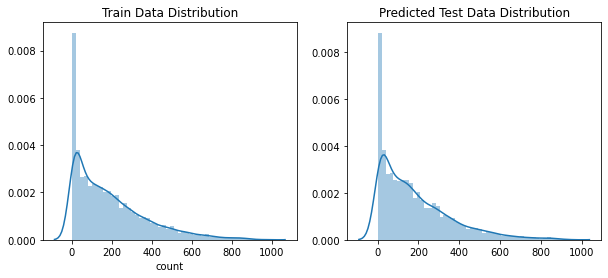

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = rf_best_estimator.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.distplot(y, ax=axes[0], bins=50)
axes[0].set_title('Train Data Distribution')
sns.distplot(np.exp(randomforest_preds), ax=axes[1], bins=50)
axes[1].set_title('Predicted Test Data Distribution');

#### 제출 파일 생성

In [16]:
submission['count'] = np.exp(randomforest_preds)
submission.to_csv('submission.csv', index=False)